In [1]:
from nltk.corpus import wordnet as wn
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from concreteabstract import ConcreteAbstract

In [2]:
# Hyperparameters

#concreteness_threshold = 2
concreteness_threshold = 7

# Number of positive examples we want for each classifier
#pos_count = 3
#neg_count = 9
pos_count = 10
neg_count = 20
#pos_count = 15
#neg_count = 40


test_pct = 0.33 #0.33

embedding_file = 'ddata/clip.bertvocab.embeddings.513.txt'
embedding_pickle = 'ddata/clip.bertvocab.embeddings.513.pkl'
concreteness_file = 'ddata/AC_ratings_google3m_koeper_SiW.csv'
concreteness_pickle = 'ddata/AC_ratings_google3m_koeper_SiW.pkl'

In [3]:
# wac2vec

if os.path.isfile(embedding_pickle):
    wac2vec = pickle.load(open(embedding_pickle, 'rb'))
else:
    with open(embedding_file) as f:
        f = f.readlines()
        f = [line.split() for line in f]
        wac2vec = {line[0]:np.array(line[1:], dtype=np.float64) for line in f}
        pickle.dump(wac2vec, open(embedding_pickle, "wb" ))

len(wac2vec)

30522

In [4]:
# concr_scores

if os.path.isfile(concreteness_pickle):
    concr_scores = pickle.load(open(concreteness_pickle, 'rb'))
else:
    concr_scores = pd.read_csv(concreteness_file, delimiter='\t')
    concr_scores = concr_scores.dropna()
    concr_scores.WORD = concr_scores.WORD.apply(lambda x: x.replace("_", " "))
    concr_scores.index = concr_scores.WORD
    pickle.dump(concr_scores, open(concreteness_pickle, "wb" ))

len(concr_scores)

2168990

In [26]:
ca = ConcreteAbstract(wac2vec, concr_scores, wn, pos_count=3, neg_count=5)
ca.build_all(min_rating=4, test_pct=0.3, verbose=True)
score, rand_baseline = ca.evaluate_vs_distractors(10)
print("score:    ", score)
print("baseline: ", rand_baseline)

Initiate Abstraction Tree


  0%|          | 0/14510 [00:00<?, ?it/s]

Grow Abstraction Tree


  0%|          | 0/4861 [00:00<?, ?it/s]

Add Positive and Negative examples


  0%|          | 0/1031 [00:00<?, ?it/s]

Fill out Train and Test sets


  0%|          | 0/1031 [00:00<?, ?it/s]

Build Classifiers


  0%|          | 0/1031 [00:00<?, ?it/s]

Done


  0%|          | 0/1031 [00:00<?, ?it/s]

score:     0.3224390243902439
baseline:  0.09138730385164051


In [27]:
ca.set_verbose(False)

In [28]:
X = range(2, 50)

In [29]:
scores_baselines = [ca.evaluate_vs_distractors(x) for x in X]

In [30]:
scores, baselines = zip(*scores_baselines)

In [31]:
#scores

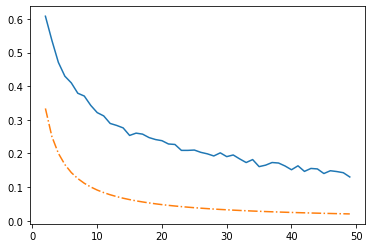

In [32]:
plt.plot(X, scores)
plt.plot(X, baselines, '-.')
plt.show()

In [33]:
scores[-1]

0.1302439024390244